# TRIEST Counting Triangles
### Adam Gibbs
### COSC 254
### 7 May 2021

This notebook performs the analysis of the implementations of TRIEST Base and TRIEST Improved. The notebook will parse the output files and then get the min, max, median, first quartile, and third quartile of triangle estimates over the 20 test runs of the algorithm and then plotting these stats over time. The notebook is organized as follows:

1. Code of methods to parse estimates from output files and calculate stats
2. Running methods to parse estimates and calculate stats in parallel
3. Plot stats of estimates vs time
4. Discussion of plots and performance of implementations

All the code for the implementations and the output files are on in the GitHub repo: https://github.com/adamggibbs/cosc254-graph-triangle-counting if you would like to run the jupyter notebook (takes about 3.5 min).

In [1]:
# IMPORTS AND GLOBALS

import numpy as np
from matplotlib import pyplot as plt
from multiprocessing import Process
from multiprocessing import Manager
import time

# size of the graph and expected number of triangles
ds_size = 198110
expectation = 1351441

# dir with output files from sample runs
output_dir = '../output2/'

# sample sizes used
sample_sizes = [5000, 10000, 20000, 30000, 40000]
# line styles for graphs
sample_labels = ["solid", "dashed", "dotted", "dashdot", (0, (5, 10))]


In [2]:
# GET OUTPUTS; THEN GET MIN, MAX, MEDIAN, FIRST Q, THIRD Q METHODS

# method to get the outputs from the 20 runs for each sample size
# designed to be run in parallel so it takes in a dict to store output array
# optional parameter to specify whether to get baseline or improved run outputs

# GET_OUTPUTS()
def get_outputs(dict, impr=False):

    # create array to store outputs
    outputs = np.empty((ds_size, 5, 20))

    k = 0
    for i in sample_sizes:

        for j in range(0,20):
            
            # change output file name depending on whether
            # were analyzing baseline for improved implementation
            if impr:
                output_file = output_dir + "output." + str(i) + "I." + str(j) + ".txt"
            else:
                output_file = output_dir + "output." + str(i) + "." + str(j) + ".txt"
            
            with open(output_file, "rt") as file:
                # add each line to output array
                # store in array as outputs[time][sample size][run number]
                # since this is how we loop through to create plot statistics
                # this improves performance thru cache locality
                line_num = 0
                for line in file:
                    outputs[line_num][k][j] = line
                    line_num += 1
        k += 1
    # store output in dict
    if impr:
        dict['i'] = outputs
    else:
        dict['b'] = outputs



# following methods are designed to get plot statistics
# all loop through outputs array and get desired statistic 
# for each t and for every sample size over the 20 runs
# these are designed to be run in parallel later, hence the dict for output

# GET_MIN()
def get_min(outputs, dict, impr=False):
    min_l = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            # get est at t for all 20 runs
            t_list = np.empty(20)
            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            # find and store min
            min_l[i][t] = np.amin(t_list)
    # store output
    key = 'min_l'
    if impr:
        key += "_i"        
    dict[key] = min_l

# GET_MAX()
def get_max(outputs, dict, impr=False):
    max_l = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            # get est at t for all 20 runs
            t_list = np.empty(20)
            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            # find and store max
            max_l[i][t] = np.amax(t_list)
    # store output
    key = 'max_l'
    if impr:
        key += "_i"        
    dict[key] = max_l

# GET_MEDIAN
def get_median(outputs, dict, impr=False):
    median_l = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            # get est at t for all 20 runs
            t_list = np.empty(20)
            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            # find and store median
            median_l[i][t] = np.median(t_list)
    # store output
    key = 'median_l'
    if impr:
        key += "_i"        
    dict[key] = median_l

# GET_FIRST()
def get_first(outputs, dict, impr=False):
    first = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            # get est at t for all 20 runs
            t_list = np.empty(20)
            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            # find and store first quantile
            first[i][t] = np.quantile(t_list,0.25)
    # store output
    key = 'first'
    if impr:
        key += "_i"        
    dict[key] = first

# GET_THIRD()
def get_third(outputs, dict, impr=False):
    third = np.empty((5, ds_size))
    for t in range(0, ds_size):
        for i in range(0,5):
            # get est at t for all 20 runs
            t_list = np.empty(20)
            for j in range(0,20):
                t_list[j] = int(outputs[t][i][j])
            # find and store third quantile
            third[i][t] = np.quantile(t_list,0.75)
    # store output
    key = 'third'
    if impr:
        key += "_i"        
    dict[key] = third
        

In [3]:
# GET SUMMARY STATISTICS VS TIME ARRAYS FOR EACH SAMPLE SIZE TO PLOT

# create dict to store output of threads getting statistics
manager = Manager()
dict = manager.dict()

# get the output from baseline and improved runs
pb = Process(target=get_outputs, args=(dict,)); pb.start()
pi = Process(target=get_outputs, args=(dict, True)); pi.start()
# wait for threads to finish
pb.join(); pi.join()
# get outputs
outputs_b = dict['b']
outputs_i = dict['i']

# get summary stats for each stat and each implementation
p1 = Process(target=get_min, args=(outputs_b, dict)); p1.start()
p2 = Process(target=get_max, args=(outputs_b, dict)); p2.start()
p3 = Process(target=get_median, args=(outputs_b, dict)); p3.start()
p4 = Process(target=get_first, args=(outputs_b, dict)); p4.start()
p5 = Process(target=get_third, args=(outputs_b, dict)); p5.start()
p6 = Process(target=get_min, args=(outputs_i, dict, True)); p6.start()
p7 = Process(target=get_max, args=(outputs_i, dict, True)); p7.start()
p8 = Process(target=get_median, args=(outputs_i, dict, True)); p8.start()
p9 = Process(target=get_first, args=(outputs_i, dict, True)); p9.start()
p10 = Process(target=get_third, args=(outputs_i, dict, True)); p10.start()
# wait for all threads to finish
p1.join(); p2.join(); p3.join(); p4.join(); p5.join(); p6.join(); p7.join(); p8.join(); p9.join(); p10.join()
# get all the summary stats
min_l = dict['min_l']; max_l = dict['max_l']; median_l = dict['median_l']; first = dict['first']; third = dict['third']
min_l_i = dict['min_l_i']; max_l_i = dict['max_l_i']; median_l_i = dict['median_l_i']; first_i = dict['first_i']; third_i = dict['third_i']
# delete the output arrays because they're huge
del outputs_b, outputs_i


## Plots
The following 10 cells contain plots of the min, max, median, first quartile, third quartile in that order for the baseline and improved implementations, respectively. 

Each plot contains the stat on the y-axis against the time on the x-axis. A horizontal line at the expected number of triangles in the graph is added to provide context for the estimates.  

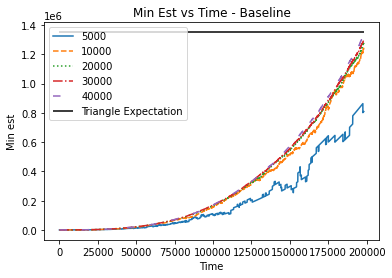

In [4]:
# MIN PLOT FOR BASELINE

for i in range(0,5):
    plt.plot(range(0,ds_size), min_l[i], 
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Min Est vs Time - Baseline")
plt.xlabel("Time")
plt.ylabel("Min est")
plt.legend()
plt.show()

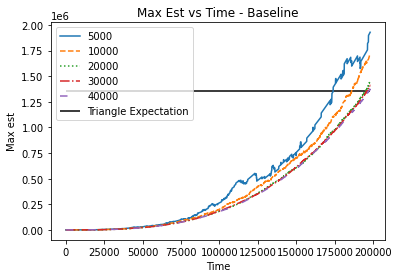

In [5]:
# MAX PLOT FOR BASELINE

for i in range(0,5):
    plt.plot(range(0,ds_size), max_l[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Max Est vs Time - Baseline")
plt.xlabel("Time")
plt.ylabel("Max est")
plt.legend()
plt.show()

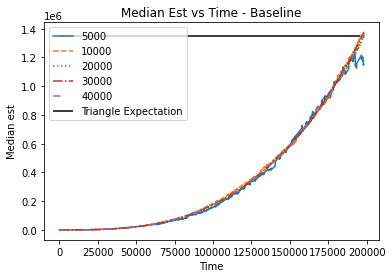

In [6]:
# MEDIAN PLOT FOR BASELINE

for i in range(0,5):
    plt.plot(range(0,ds_size), median_l[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Median Est vs Time - Baseline")
plt.xlabel("Time")
plt.ylabel("Median est")
plt.legend()
plt.show()

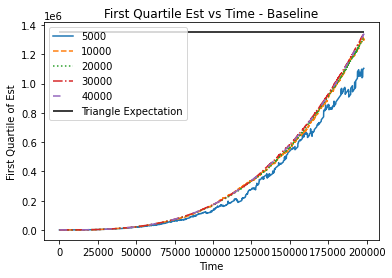

In [7]:
# FIRST QUARTILE PLOT FOR BASELINE

for i in range(0,5):
    plt.plot(range(0,ds_size),first[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("First Quartile Est vs Time - Baseline")
plt.xlabel("Time")
plt.ylabel("First Quartile of Est")
plt.legend()
plt.show()

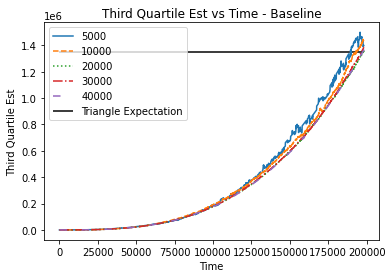

In [8]:
# THIRD QUARTILE PLOT FOR BASELINE

for i in range(0,5):
    plt.plot(range(0,ds_size), third[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Third Quartile Est vs Time - Baseline")
plt.xlabel("Time")
plt.ylabel("Third Quartile Est")
plt.legend()
plt.show()

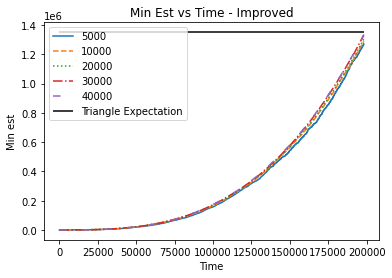

In [9]:
# MIN PLOT FOR IMPROVED 

for i in range(0,5):
    plt.plot(range(0,ds_size), min_l_i[i], 
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Min Est vs Time - Improved")
plt.xlabel("Time")
plt.ylabel("Min est")
plt.legend()
plt.show()

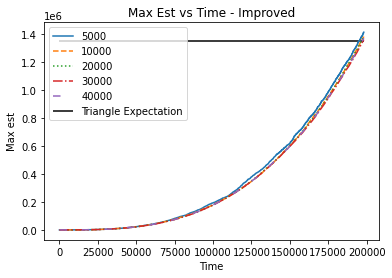

In [10]:
# MAX PLOT FOR IMPROVED

for i in range(0,5):
    plt.plot(range(0,ds_size), max_l_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Max Est vs Time - Improved")
plt.xlabel("Time")
plt.ylabel("Max est")
plt.legend()
plt.show()

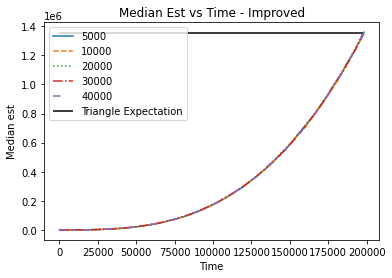

In [11]:
# MEDIAN PLOT FOR IMPROVED

for i in range(0,5):
    plt.plot(range(0,ds_size), median_l_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Median Est vs Time - Improved")
plt.xlabel("Time")
plt.ylabel("Median est")
plt.legend()
plt.show()

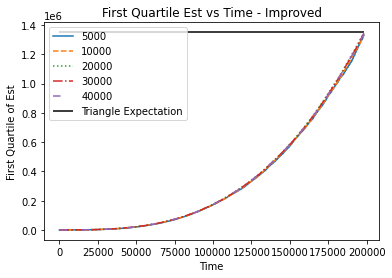

In [12]:
# FIRST QUARTILE PLOT FOR IMPROVED

for i in range(0,5):
    plt.plot(range(0,ds_size),first_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("First Quartile Est vs Time - Improved")
plt.xlabel("Time")
plt.ylabel("First Quartile of Est")
plt.legend()
plt.show()

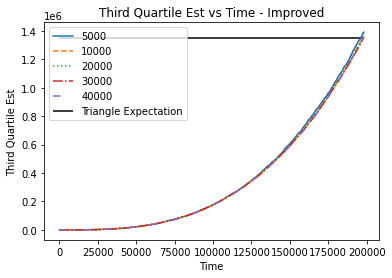

In [13]:
# THIRD QUARTILE PLOT FOR IMPROVED

for i in range(0,5):
    plt.plot(range(0,ds_size), third_i[i],
             label=str(sample_sizes[i]), linestyle=sample_labels[i])

plt.hlines(1351441, 0, ds_size, colors='black', label='Triangle Expectation')
plt.title("Third Quartile Est vs Time - Improved")
plt.xlabel("Time")
plt.ylabel("Third Quartile Est")
plt.legend()
plt.show()

## Discussion
#### General
For the report I ran the implementations on the <b>ca-AstroPh.txt</b> graph. In terms of runtime, the implementations took approximately the same amount of time to run on all sample sizes (about 2-3 seconds). In terms of accuracy, the baseline algorithm at small sample sizes performed significantly worse than the improved implementation and at the higher sample sizes the improved implementation still performed better but the baseline implementation had comparable accuracy. As for the shape of all the plots, the slope of the curves (on average) is constantly increasing so all the plots are noticeably concave up. This pattern is probably because as more edges are added it is more likely that an addition creates a triangle because there are already so many edges in the graph. I'd predict that the rate that which the slope increases would be related to the density of the graph as a denser graph would see the number of triangles increase more dramatically as many edges are added compared to a dense graph where adding edges usually means adding new nodes with cannot create a triangle. In the next few sections I'll discuss observations of each implementation and then compare the two.

#### Baseline
The baseline implementation at sample sizes 5000 and 10000 did not perform well at all. The sample size 5000 max was nearly 2,000,000 triangles which is 650000 triangles over the actual value and the sample size 5000 min was also noticeably lower being about 550000 less than the actual. The sample size 10000 min and max performed better but still were poor estimates of the actual number of triangles. The min and max plots for sample sizes 20000, 30000, and 40000, however, were fairly reasonable but they still were noticeably off from the actual. The first and third quartiles followed a similar pattern to the min and max plots, but with less error which is expected as the min is less than the first quartile and max is more than the third quartile. As for the median, the median of the 5000 sample size was still a relatively bad estimate. However, the median improved greatly with the sample size 10000 estimate and then the estimates of the 20000, 30000, and 40000 sample sizes were comparable to the estimates of the improved run. These estimates from high sample sizes were mostly within a few ten-thousands of triangles off the expected number of triangles. And this makes sense as we expect the estimate to be better as we increase our sample size. This is because we're comparing each incoming egde to a graph that is closer to the actual graph. It is also worth noting that some individual runs of the baseline algorithm with high sample sizes estimated the actual value to within about one-thousand triangles. Another important observation is that the plots of the baseline implementation are not strictly increasing and can have significant drops in estimates from one time step to the next, especially on the extremes like min and max. 

#### Improved
The median of the improved implementation was very accurate at each of the sample sizes. The sample size 5000 median is actually the only one you can visibily see on the plot that doesn't perfectly meet the horizontal line of the actual number of triangles. The same follows for the first and third quartiles as well except for that the line for the 5000 sample size begins to drift away from the rest of the lines as time increases. On the plots of min and max the estimates of the 5000 sample size can be clearly discerned from the rest but only after about timestep 125000 and then the difference gets larger as time increases. This behavior was surprising as extremely low sample sizes create a very accurate estimate when taking the median over multiple runs. Also, if each run is taken individually, the estimates are still fairly accurate as the lack of diverge on the min and max plots show the variance between runs is quite small. Also, an important observation is that the curves are very smooth and they appear at a higher level to be strictly increasing. In fact, for each run the estimates necessarily are strictly increasing but by virute of the statistics, there may be very small intervals were the estimate may decrease slightly, but not enough to be seen at this scope. Overall, the performance of this implementation shows why its called the "improved" implementation.

#### Comparison
The improved implementation clearly performed much better than the baseline implementation. They performed similarly at the larger sample sizes of 30000 and 40000 but at the smaller sample sizes the improved implementation performed much better. The median improved run of sample size 5000 performed about as good as the median improved run from the baseline implementation. The variance between runs at all sample sizes of the improved run was also much smaller which suggests that similar results could probably be obtained with fewer than 20 runs. And with a pretty good probably, a single improved run would perform as good as the median of many baseline runs of a higher sample size. These become important as we consider larger graphs. This graph is relatively small and on my little laptop it ran quite efficiently. But on significantly larger graphs, being able to obtain accurate estimates with fewer runs and at lower sample sizes can save a lot of time, memory, and power which are all very important to consider at scale. Further, beyond performance and final accuracy, the improved run gives a better estimate of the way the graph evolves. The graphs we're analyzing are insertion only graphs so the number of triangles should never decrease as time increases. With the improved run, the estimate can never decrease as every edge either adds triangles or adds no triangles and when edges are removed from the sample, the triangles they created are not decremented from the triangle count. As mentioned before this more accurately represents an insertion only dynamic graph. Overall, the better accuracy and lower variance of the improved algorithm makes its estimates much better than the baseline implementation in terms of scalability and desired output. However, the baseline implementation still performs well at reasonable sample sizes and in a reasonable amount of time, especially for smaller graphs. So the baseline implementation is not necessarilly bad, but the improved run performs noticeably better.  
